In [1]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.2 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import cv2 as cv  # OpenCV library for image processing
import os  # Operating system module for file and directory manipulation
import tensorflow as tf  # TensorFlow library for deep learning
import matplotlib.pyplot as plt  # Matplotlib for visualization
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set TensorFlow log level to suppress unnecessary messages

In [3]:
# Read an image using OpenCV
img = cv.imread("/content/drive/MyDrive/Face recognition /Dataset/Maria (princess)/IMG_20240301_091610.jpg")

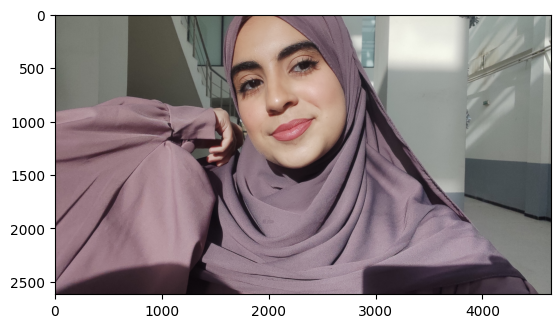

In [4]:
# convert the color space from BGR to RGB
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# Display the image using Matplotlib
plt.imshow(img)

In [5]:
# Import the MTCNN (Multi-Task Cascaded Convolutional Neural Network) for face detection
from mtcnn.mtcnn import MTCNN
# Create an instance of MTCNN and Detect faces in the image
detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 181ms/step


In [6]:
results

[{'box': [1582, 5, 1168, 1446],
  'confidence': 0.9999329447746277,
  'keypoints': {'left_eye': (1825, 656),
   'right_eye': (2308, 467),
   'nose': (2083, 816),
   'mouth_left': (1990, 1129),
   'mouth_right': (2439, 967)}}]

In [7]:
#Extract the bounding box coordinates of the first detected face
x,y,w,h = results[0]['box']

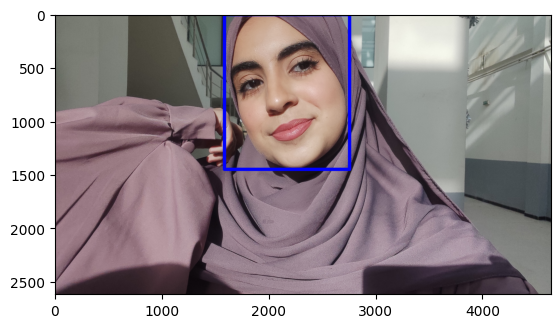

In [8]:
# Draw a rectangle around the detected face
img = cv.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 30)
plt.imshow(img)

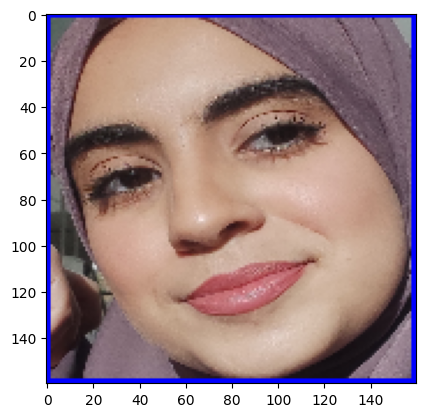

In [9]:
# Extract the detected face and resize it to a standard size
my_face = img[y:y+h , x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

automate the preprocessing

In [10]:
# Define a class to load and preprocess face images
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    # Function to extract and preprocess a face from an image file
    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr

    # Function to load faces from a directory and preprocess them
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES


     #Function to load faces from multiple directories and assign labels
    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)

     # Function to plot preprocessed face images
    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [11]:
import numpy as np
# Create an instance of FACELOADING class and load face images
faceloading = FACELOADING("/content/drive/MyDrive/Face recognition /Dataset")
X,Y = faceloading.load_classes()

1/1 [==============================] - 0s 43ms/step
Loaded successfully: 3
1/1 [==============================] - 0s 34ms/step
Loaded successfully: 6
1/1 [==============================] - 0s 32ms/step
Loaded successfully: 6
1/1 [==============================] - 0s 36ms/step
Loaded successfully: 3
1/1 [==============================] - 0s 43ms/step
Loaded successfully: 6
1/1 [==============================] - 0s 36ms/step
Loaded successfully: 2
2/2 [==============================] - 0s 36ms/step
Loaded successfully: 3
1/1 [==============================] - 0s 35ms/step
Loaded successfully: 5


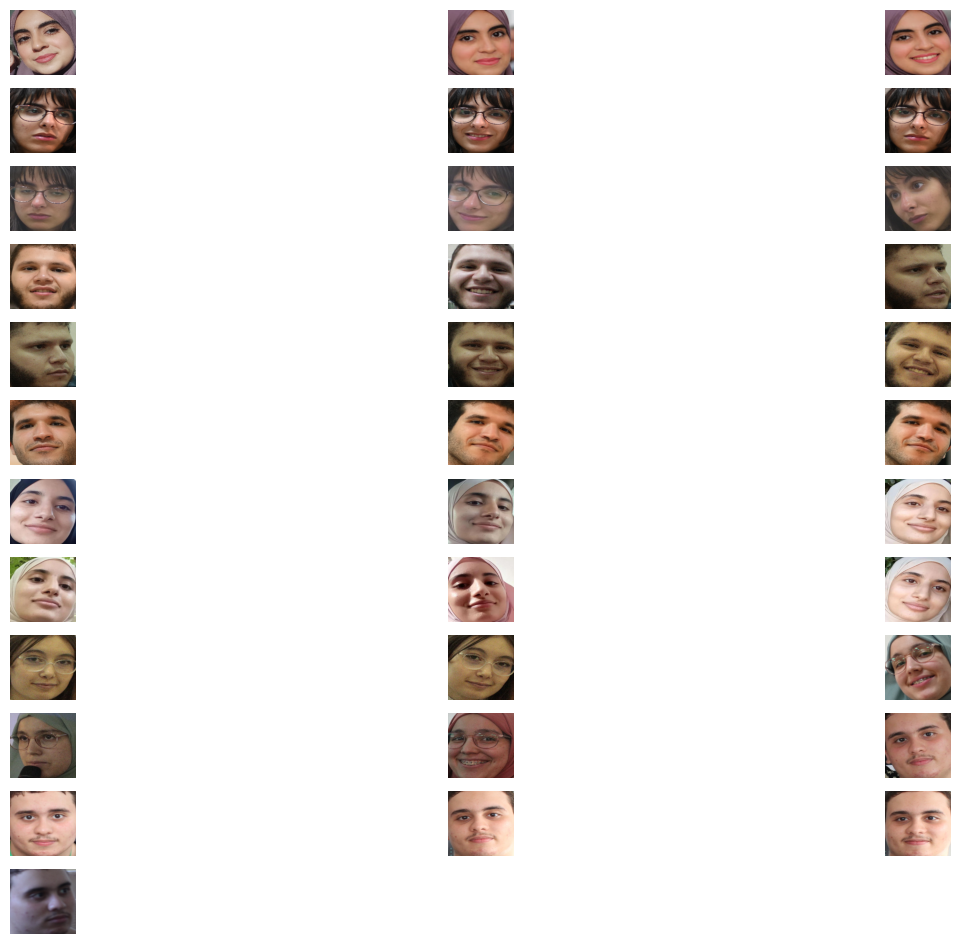

In [12]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

FACENET part

In [13]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=5dee4b3201c42df81fd01b6d6295e70d6ab63ae7547a6fb92fc8568037296207
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [14]:
from keras_facenet import FaceNet
embedder = FaceNet()
# Function to get face embeddings using the FaceNet model
def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [15]:
# Get face embeddings for all loaded face images
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 194ms/step


In [16]:
# Save the face embeddings and corresponding labels
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

SVM model

In [17]:
# Preprocess labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '2')

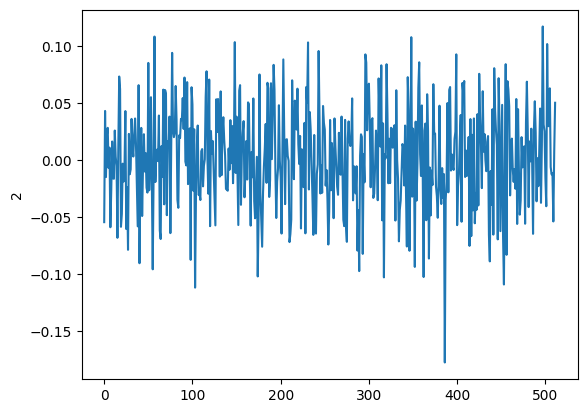

In [18]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [19]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [20]:
from sklearn.svm import SVC
# Train an SVM model on the training data
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [21]:
# Make predictions on the training and testing data
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [22]:
# Calculate accuracy scores
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [23]:
accuracy_score(Y_test,ypreds_test)

0.8888888888888888

In [24]:
# Read a test image and extract the face
t_im = cv.imread("/content/drive/MyDrive/Face recognition /Dataset/Miko/DSC_1513.JPG")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 50ms/step


In [25]:
# Get embedding for the test face image
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 84ms/step


In [26]:
test_im = [test_im]
# Make predictions on the test image
ypreds = model.predict(test_im)

In [27]:
ypreds

array([3])

In [30]:
# Inverse transform predictions to get original labels
encoder.inverse_transform(ypreds)

array(['Miko'], dtype='<U16')

In [31]:
# Save the trained SVM model
import pickle
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)